<a href="https://colab.research.google.com/github/shuuuuyu/114-1-Programing-Language/blob/main/hw_1_%E6%97%A5%E5%B8%B8%E6%94%AF%E5%87%BA%E9%80%9F%E7%AE%97%E8%88%87%E5%88%86%E6%94%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 記帳軟體作業說明


## 目標
設計一個簡易的記帳系統，功能包含：
1. **AA 功能**：計算每人分攤金額，並記錄至 Google Sheet。
2. **記帳功能**：記錄消費的時間、種類、金額、項目名稱與備註。
3. **AI 點子板塊**：分析最近一週的消費，提供統計與建議。

## 功能板塊

### 1. AA 功能
- 輸入總金額。
- 選擇服務費百分比（0%、5%、10%）。
- 輸入分攤人數。
- 額外輸入餐點或描述文字。
- 系統會計算每人應付金額，並寫入 Google Sheet 的「外食」欄位。

### 2. 記帳功能
- 輸入以下欄位：
  - 消費種類：外食、買菜、日用品
  - 金額
  - 項目名稱（如餐廳名稱、材料名稱、日用品名稱）
  - 備註
- 記錄會直接寫入 Google Sheet。
- Google Sheet 設定為「知道連結的使用者可以編輯」，無需服務帳號憑證。

### 3. AI 點子板塊
- 顯示最近一週的消費：
  - 每個種類的總金額
  - 每筆消費明細
- AI 分析功能：
  - 後續可使用模型提供消費習慣分析與建議（例如「外食過多」）
- **我使用的是groq api**


## 使用方式
1. 開啟程式，會跳出 Google 登入授權視窗，登入後可操作 Google Sheet。
2. 在 **AA 功能** 或 **記帳功能** 填入資料，按下送出按鈕，即可寫入 Google Sheet。
3. 前往 **AI 點子板塊**，點擊「查看最近一週消費」以統計消費資料。
4. AI 建議按鈕目前保留，後續可補上分析模型。

---

## Google Sheet 格式
- Sheet 欄位：
  - 時間
  - 種類
  - 金額
  - 項目名稱
  - 備註
- 系統會自動將資料新增至該 Sheet。

---

## 備註
- 程式使用 Google OAuth 登入，不需 Service Account JSON。
- AA 功能會將分攤後金額寫入 Google Sheet，方便統計。
- 程式使用 Gradio 建立簡易網頁介面，方便操作。

# 程式部分

## 設定AI

In [1]:
import os
from google.colab import userdata
from openai import OpenAI

In [2]:
!pip install openai
!pip install gradio

In [3]:
title = "理財消費分析器"

system = '''你是一位專業的消費與理財分析專家，專門協助使用者了解消費習慣並給予實用建議。
請根據輸入的消費數據，輸出簡明扼要的分析與建議，語氣親切且清晰。

輸出格式請遵守以下規則：
1. 第一段為完整的一個段落：先用一句話說明整體消費習慣，再用一句話說明主要花費的金額占比。
2. 第二段提供節省或調整建議，約三句，務必實用且可執行。
3. 第三段給簡單的理財提醒與下一步行動建議，不超過三句。

請用台灣常用的繁體中文，避免使用任何標題、項目符號或 Markdown 語法，直接輸出自然段落文字即可。
'''

#description =
'''想要快速了解自己的消費狀況並獲得改善建議？
這個生成器會分析最近的消費數據，告訴你整體消費習慣、主要花費分布，並提供節省建議與理財提醒，幫助你更有效地規劃財務。
'''


'想要快速了解自己的消費狀況並獲得改善建議？\n這個生成器會分析最近的消費數據，告訴你整體消費習慣、主要花費分布，並提供節省建議與理財提醒，幫助你更有效地規劃財務。\n'

In [4]:
messages = [{"role":"system",
             "content":system}]


api_key = userdata.get('groq-pl')
model = "qwen/qwen3-32b"
base_url="https://api.groq.com/openai/v1"


client = OpenAI(
    base_url = base_url # 如用 OpenAI 不需要這一行
)

os.environ['OPENAI_API_KEY']=api_key

def mychatbot(prompt):
    messages.append({"role": "user", "content": prompt})
    chat_completion = client.chat.completions.create(
        messages=messages,
        model=model,
        )
    reply = chat_completion.choices[0].message.content
    return reply

SecretNotFoundError: Secret groq-pl does not exist.

## 主要程式

In [ ]:
# 掛載與套件載入
import pandas as pd
import gradio as gr
import datetime
import gspread
from google.colab import auth
from google.auth.transport.requests import Request
from google.auth import default

# Google 帳號授權
auth.authenticate_user()   # 會跳出 Google 登入
creds, _ = default()
gc = gspread.authorize(creds)

# 你的 Google Sheet ID
SHEET_ID = "1MbCem2-X-1vTViIxN9j5Eu_C6fh-AtZQkTaIrzOE7Ok"

# 打開第一個工作表
sh = gc.open_by_key(SHEET_ID)
worksheet = sh.sheet1


In [ ]:
def calculate_aa(total_amount, service_fee_percent, people_count):
    if service_fee_percent is None:
        service_fee_percent = 0
    if people_count is None or people_count <= 0:
        people_count = 1
    final_amount = total_amount * (1 + service_fee_percent / 100)
    per_person = final_amount / people_count
    return f"總金額 {final_amount:.2f} 元，每人分攤 {per_person:.2f} 元"

def aa_function(actual_amount, description):
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    new_record = [now, "外食", actual_amount, description, "AA分攤"]
    worksheet.append_row(new_record)
    return f"已將 {actual_amount} 元-{description}新增到 Google Sheet。"

In [ ]:
# 板塊二：記帳功能
def record_expense(expense_type, amount, item_name, note):
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    new_record = [now, expense_type, amount, item_name, note]

    worksheet.append_row(new_record)

    return f"成功記錄：{expense_type} - {item_name} - {amount} 元"

In [ ]:
# 板塊三：AI 點子
def analyze_week():
    data = worksheet.get_all_records()
    df = pd.DataFrame(data)
    df["時間"] = pd.to_datetime(df["時間"], errors="coerce")

    one_week_ago = datetime.datetime.now() - datetime.timedelta(days=7)
    recent_df = df[df["時間"] >= one_week_ago]

    summary = recent_df.groupby("種類")["金額"].sum().reset_index()
    detail = recent_df[["時間", "種類", "金額", "項目名稱"]]

    return summary, detail

def format_data_for_ai(summary_df, detail_df):
    """將 DataFrame 轉換成 AI 可讀的文字格式"""
    # 處理總結數據
    summary_text = "【最近一週消費總結】\n"
    total_amount = 0
    for _, row in summary_df.iterrows():
        amount = row["金額"]
        category = row["種類"]
        summary_text += f"- {category}: ${amount:,.0f}\n"
        total_amount += amount
    summary_text += f"\n總計: ${total_amount:,.0f}\n\n"

    # 處理詳細數據
    detail_text = "【詳細消費記錄】\n"
    for _, row in detail_df.iterrows():
        time = row["時間"].strftime("%m/%d") if pd.notna(row["時間"]) else "未知日期"
        category = row["種類"]
        amount = row["金額"]
        item = row["項目名稱"]
        detail_text += f"{time} - {category} - ${amount:,.0f} - {item}\n"

    return summary_text + detail_text

def ai_suggestion():
    """獲取 AI 建議"""
    try:
        # 先獲取最近一週的數據
        summary, detail = analyze_week()

        # 檢查是否有數據
        if summary.empty:
            return "沒有找到最近一週的消費記錄，請先添加一些消費數據。"

        # 將數據格式化為文字
        formatted_data = format_data_for_ai(summary, detail)

        # 準備 AI 分析
        system_prompt = '''你是一個消費與理財分析專家，專門分析使用者的消費數據。請以專業、清晰且友善的語氣，對以下消費數據提供建議。

                    分析內容應包括：
                    1. 消費習慣觀察（例如：外食頻率過高、日用品花費分布）
                    2. 主要花費項目與金額占比
                    3. 節省或調整建議
                    4. 理財提醒與下一步行動建議

                    請用台灣熟悉的繁體中文回答。
                    請保持語氣親切、實用，不要加不必要的示例或說明文字。
                  '''

        # 調用 AI API
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"請分析以下消費數據並提供建議：\n\n{formatted_data}"}
        ]

        chat_completion = client.chat.completions.create(
            messages=messages,
            model=model,
        )

        reply = chat_completion.choices[0].message.content
        return reply

    except Exception as e:
        return f"AI 分析過程中發生錯誤: {str(e)}"

In [ ]:
# Gradio 介面
with gr.Blocks() as demo:
    gr.Markdown("## 記帳軟體")

    # 板塊一
    with gr.Tab("AA 功能"):
        total_input = gr.Number(label="總金額")
        fee_input = gr.Dropdown([0, 5, 10, 15, 20], label="服務費 (%)", value=0)
        people_input = gr.Number(label="分攤人數", value=1)
        calc_btn = gr.Button("計算AA價格")
        aa_result = gr.Textbox(label="擬AA價格")
        actual_amount_input = gr.Number(label="實際支付金額")
        desc_input = gr.Textbox(label="餐點/描述")
        submit_btn = gr.Button("寫入試算表")
        aa_output = gr.Textbox(label="寫入結果")

        calc_btn.click(fn=calculate_aa, inputs=[total_input, fee_input, people_input], outputs=aa_result)
        submit_btn.click(fn=aa_function, inputs=[actual_amount_input, desc_input], outputs=aa_output)

    # 板塊二
    with gr.Tab("記帳功能"):
        type_input = gr.Dropdown(["外食", "買菜", "日用品"], label="種類")
        amount_input = gr.Number(label="金額")
        item_input = gr.Textbox(label="項目名稱")
        note_input = gr.Textbox(label="備註")
        record_btn = gr.Button("記錄消費")
        record_output = gr.Textbox(label="結果")
        record_btn.click(fn=record_expense, inputs=[type_input, amount_input, item_input, note_input], outputs=record_output)

    # 板塊三
    with gr.Tab("AI 點子"):
        gr.Markdown("### 💡 智能消費分析")

        with gr.Row():
            with gr.Column():
                analyze_btn = gr.Button("📊 查看最近一週消費", variant="primary")
        with gr.Row():
            with gr.Column():
                summary_output = gr.Dataframe(label="📈 各種類總結")
            with gr.Column():
                detail_output = gr.Dataframe(label="📋 詳細消費")

        with gr.Row():
            suggestion_btn = gr.Button("🤖 AI 給建議", variant="secondary")

    #事件綁定
        analyze_btn.click(
            fn=analyze_week,
            inputs=[],
            outputs=[summary_output, detail_output]
        )

        suggestion_output = gr.Textbox(
            label="🎯 AI 建議",
            lines=10,
            placeholder="點擊 'AI 給建議' 按鈕獲取個人化理財建議..."
        )

        suggestion_btn.click(
            fn=ai_suggestion,
            inputs=[],
            outputs=suggestion_output
        )



# 啟動
demo.launch()

# 運行畫面

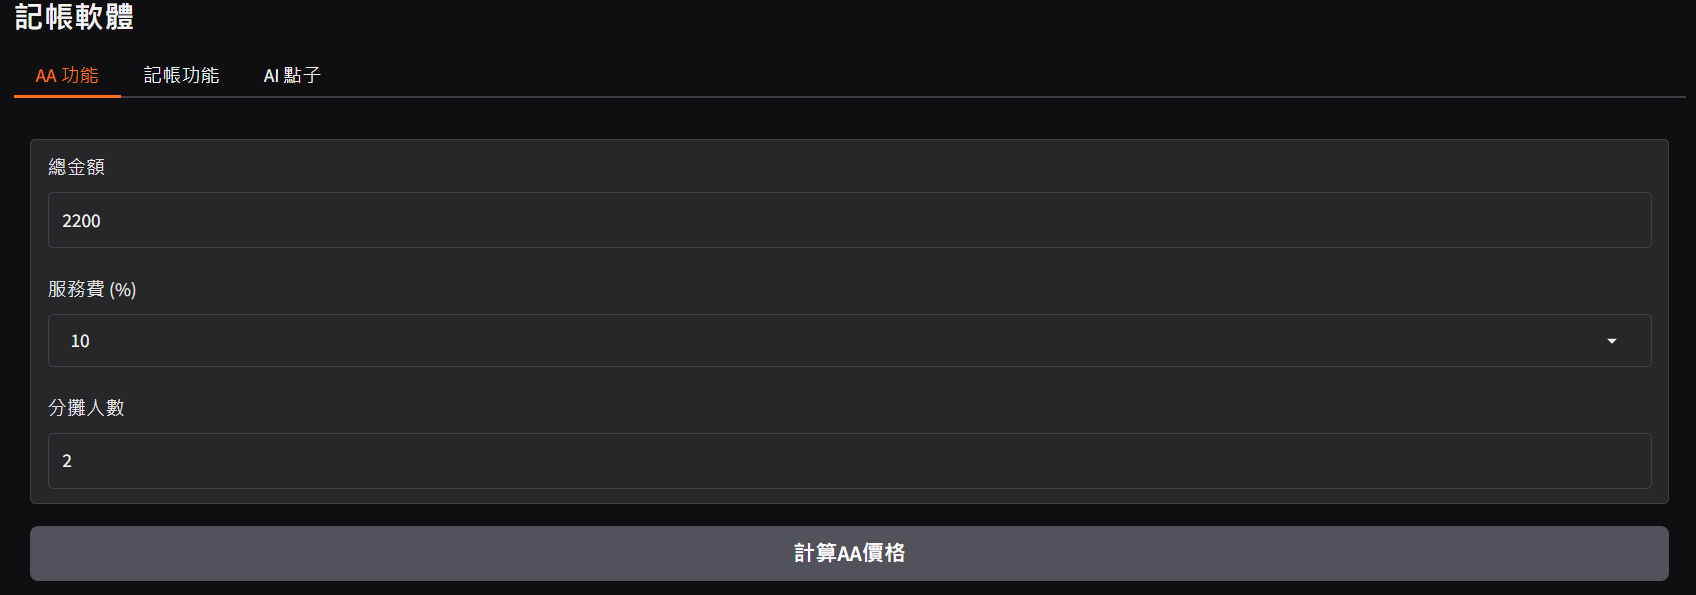

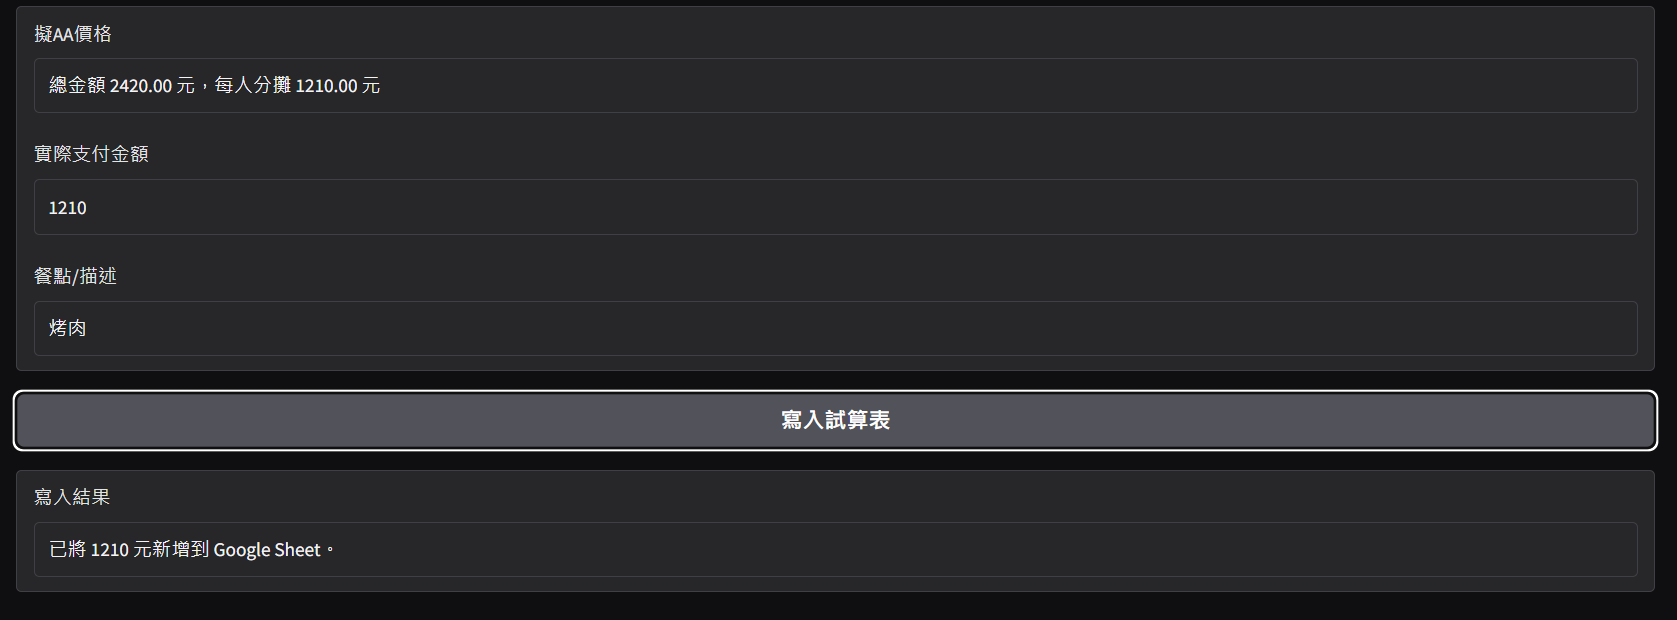

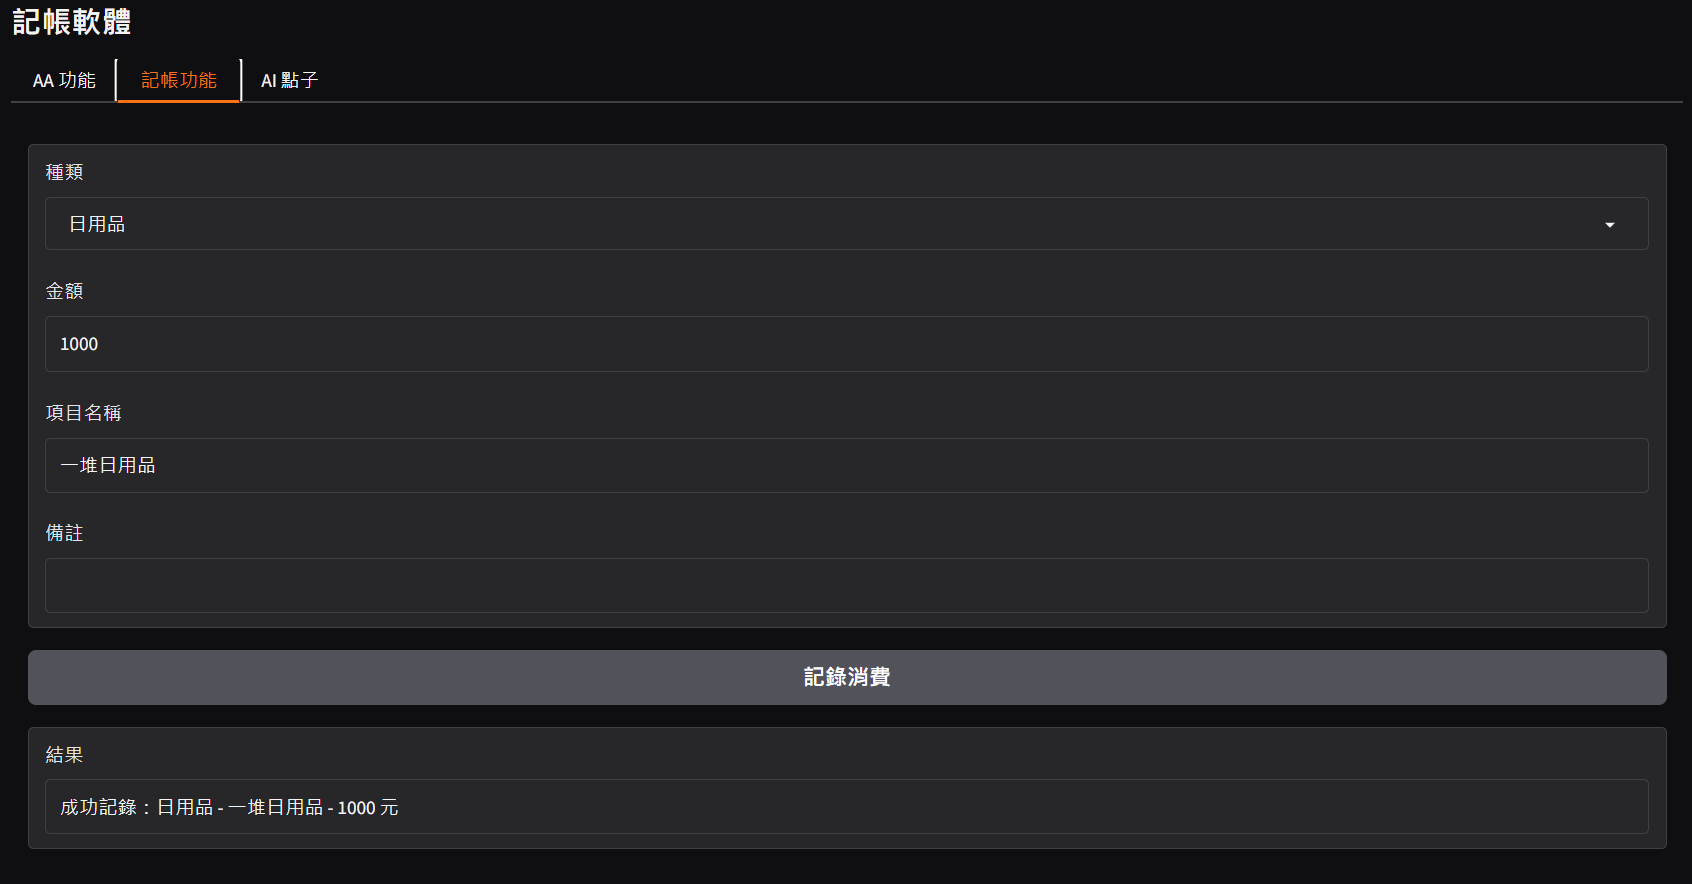

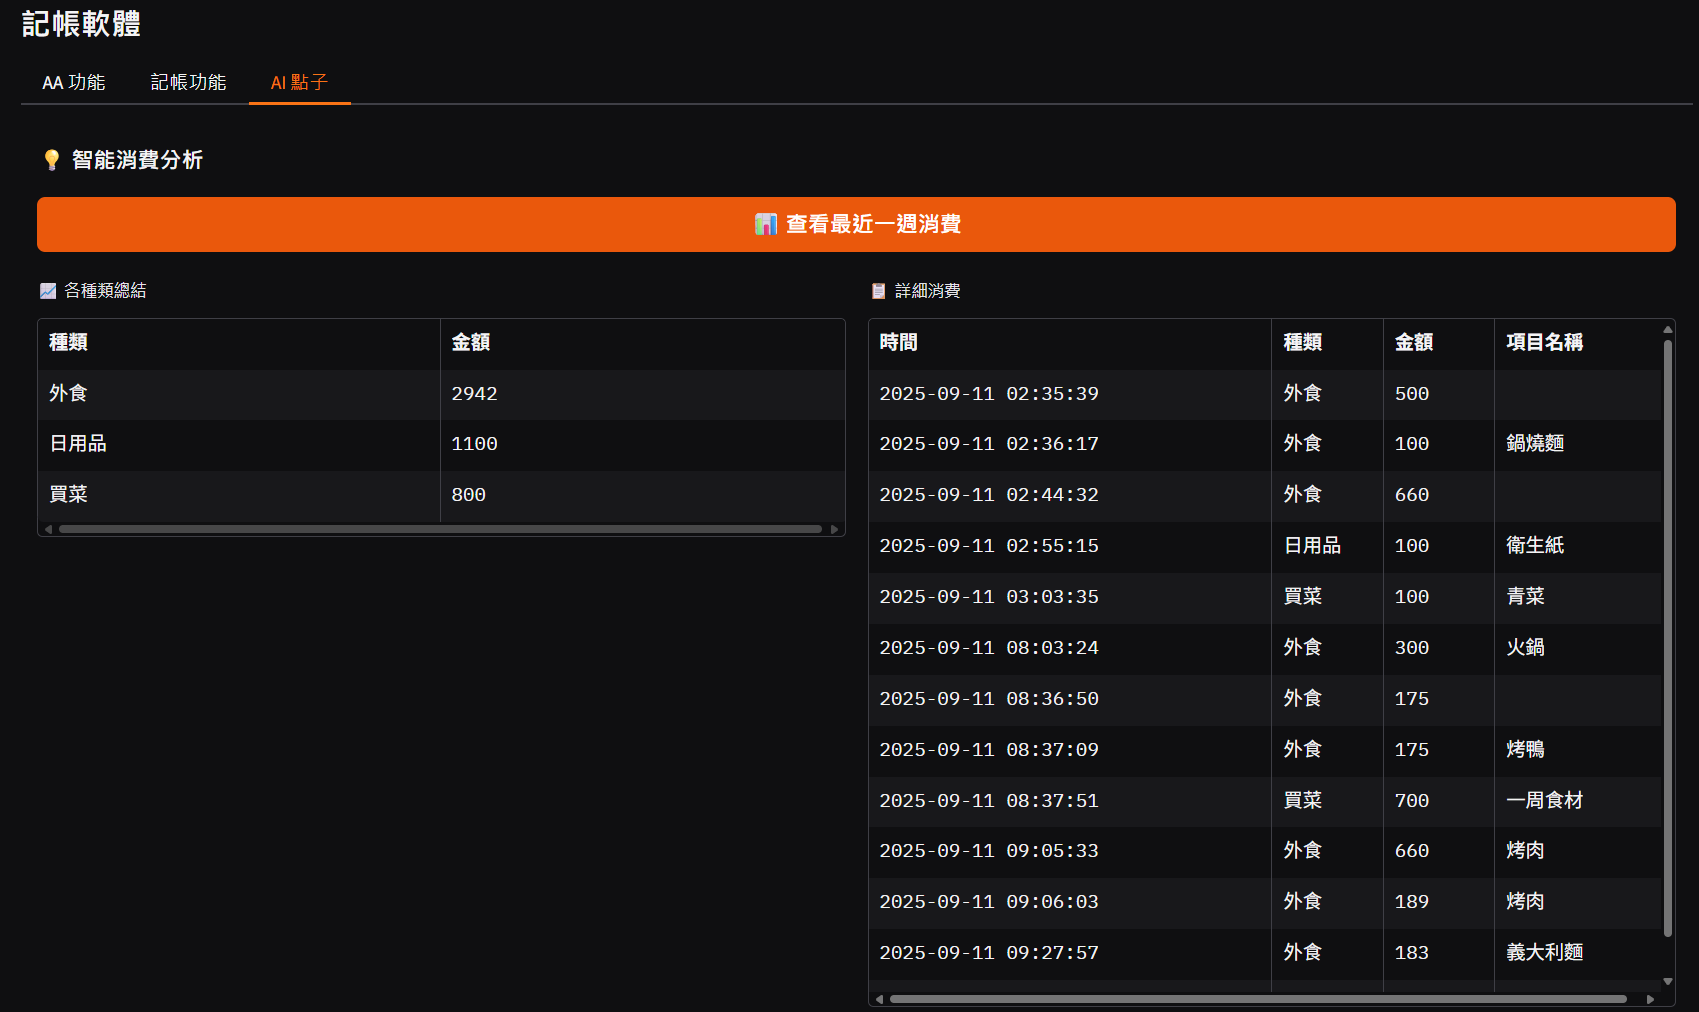

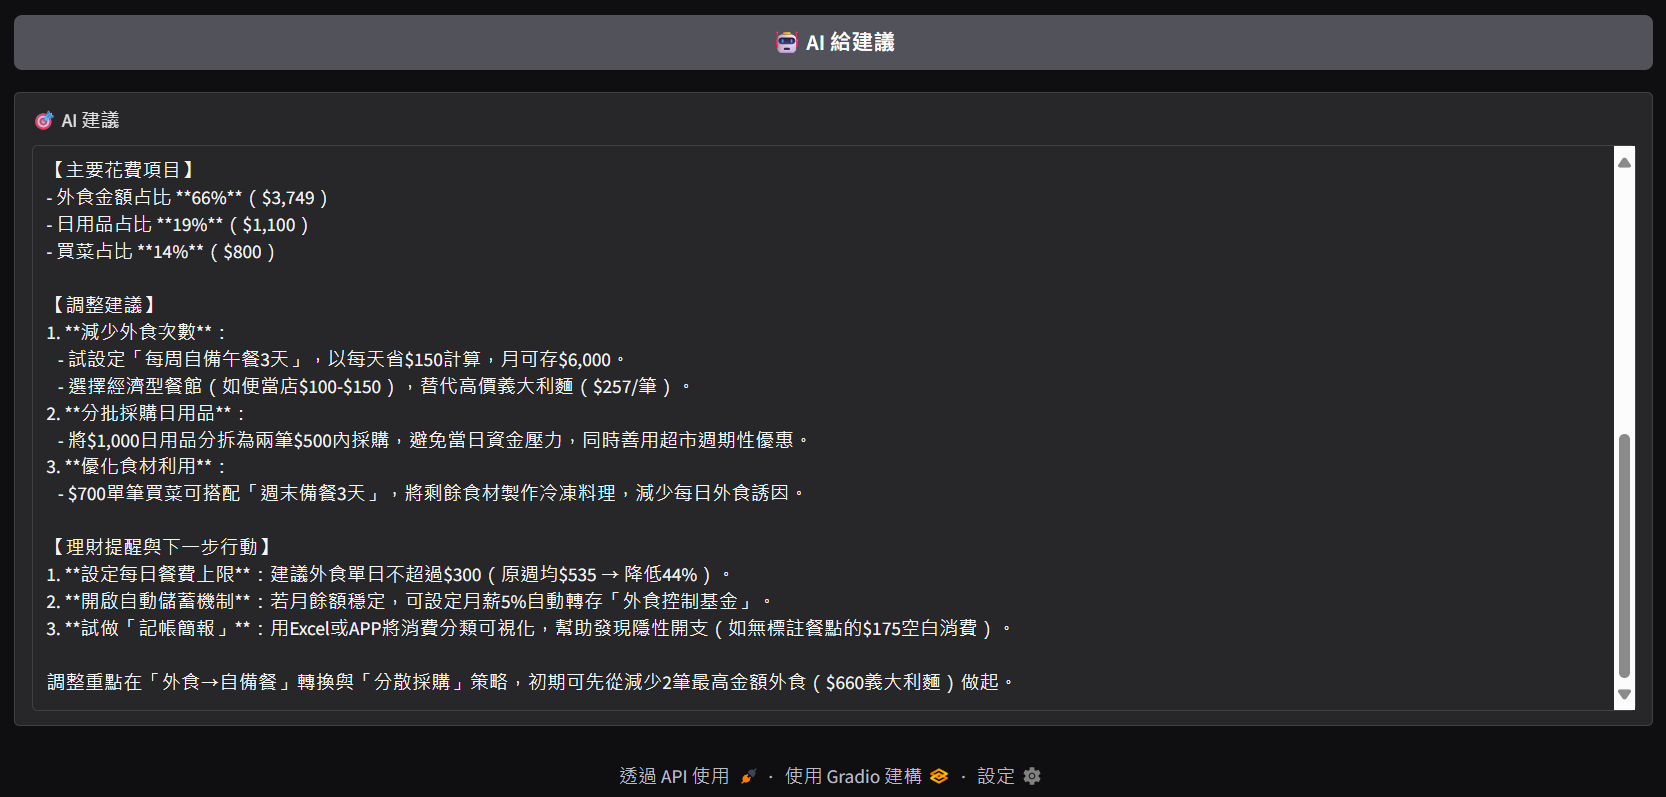

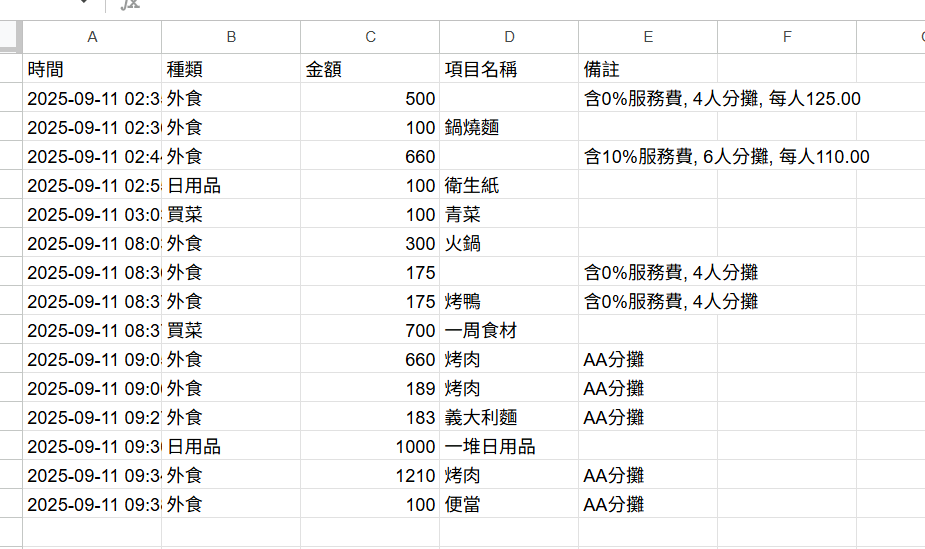


# AI 測試

In [ ]:
import os
from google.colab import userdata
from openai import OpenAI

In [ ]:
!pip install openai
!pip install gradio

In [ ]:
title = "理財消費分析器"

system = '''你是一個消費與理財分析專家，專門分析使用者的消費數據。請以專業、清晰且友善的語氣，對以下消費數據提供建議。

分析內容應包括：
1. 消費習慣觀察（例如：外食頻率過高、日用品花費分布）
2. 主要花費項目與金額占比
3. 節省或調整建議
4. 理財提醒與下一步行動建議

請用台灣熟悉的繁體中文回答。
請保持語氣親切、實用，不要加不必要的示例或說明文字。
'''

description = '''
想要了解自己的消費習慣並獲得理財建議？
這個生成器專為「消費分析與理財建議」設計。
只要提供最近一週的消費數據，它就會生成消費統計、問題觀察與改善建議，幫助你更好地掌控花費。
'''


In [ ]:
messages = [{"role":"system",
             "content":system}]

In [ ]:
api_key = userdata.get('groq-pl')
model = "qwen/qwen3-32b"
base_url="https://api.groq.com/openai/v1"

In [ ]:
client = OpenAI(
    base_url = base_url # 如用 OpenAI 不需要這一行
)

In [ ]:
os.environ['OPENAI_API_KEY']=api_key

In [ ]:
def mychatbot(prompt):
    messages.append({"role": "user", "content": prompt})
    chat_completion = client.chat.completions.create(
        messages=messages,
        model=model,
        )
    reply = chat_completion.choices[0].message.content
    return reply

In [ ]:
iface = gr.Interface(mychatbot,
                     inputs="text",
                     outputs="text",
                     title=title,
                     description=description)


iface.launch(share=True, debug=True)